## Binary representation with 3 hidden units

In [1]:
import numpy as np
from numpy import exp, sqrt, abs
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 14
from itertools import product


In [2]:
CASE=1
if CASE==0: dname="DATA"
if CASE==1: dname="DATA_b"

fname=dname+'/x_RBM_q0.1.dat'
# loading data: each row is a list of visible units
# NOTE: data "x" here is named "v" for "visible"
v = np.loadtxt(fname, delimiter=" ",dtype=int)
# store in v0, because later we will shuffle v
v0 = np.copy(v)
# to start, take a small subsample
# v = v[1:11]
N = len(v)
L = len(v[1])

#SPINS = True
SPINS = False

if SPINS:
    # sigmoid takes into account energy difference =2
    GAP=2
    # convert 0,1 -> -1,1
    v = 2*v - 1
    vmin=-1
else:
    GAP=1
    vmin=0

print(f'each of N={N} data has L={L} digits')

for i in range(min(12,N)):
    if SPINS: print(v0[i],"\n->",v[i])
    else: print(v[i])
print('...')

each of N=10000 data has L=20 digits
[0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0]
[0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1]
[0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1]
[0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0]
[0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0]
[0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0]
[0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0]
[0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1]
[1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0]
[0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0]
[0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0]
[0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0]
...


## initialize

w= [[-8.53689953e-02  1.99733179e-01 -2.16620919e-01]
 [-2.31755558e-01  8.19787168e-01  5.81090402e-01]
 [ 3.87452630e-02  1.17496268e-01  3.20704580e-01]
 [ 5.19799217e-01  4.20026997e-01 -5.40561570e-01]
 [ 1.14679439e-01  9.54632696e-02  5.64205322e-01]
 [ 3.69666589e-01 -8.34740462e-01 -1.55069058e-01]
 [ 6.96031669e-01 -1.82896223e-01 -2.25087743e-01]
 [ 1.98916500e-01  1.35490328e+00 -4.25881318e-01]
 [-2.40662042e-01  5.17621501e-02  1.26198579e-01]
 [ 2.18428052e-01  3.92122939e-04  5.60407423e-01]
 [-2.97568412e-01 -3.46614986e-01 -9.88454929e-01]
 [-7.75990891e-01 -3.58960649e-01  2.33596735e-01]
 [-5.27931178e-01  4.99713654e-02 -4.43515350e-01]
 [ 1.38821689e-01 -9.83945660e-01 -8.32151648e-02]
 [-6.43056588e-01 -4.04824860e-01 -5.45069294e-01]
 [ 1.19416099e-01  1.57630271e-01 -3.14392418e-01]
 [ 1.38155666e-01  5.62881414e-01  2.91405937e-02]
 [ 1.02870215e-01 -4.94662959e-03  4.19035400e-01]
 [ 5.53478414e-01 -3.83358570e-01 -6.46022043e-01]
 [ 9.25161718e-03  3.1625929

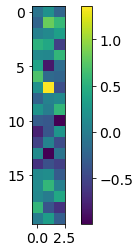

In [3]:
# RBM, nr of hidden units
if CASE==0: M = 3
if CASE==1: M = 3
# range of each initial weight
sigma = sqrt(4. / float(L + M))
# random seed for reproducibility
np.random.seed(12345)
# initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
w = sigma * np.random.randn(L,M)
a = sigma * np.random.randn(L)
b = np.zeros(M)
print("w=",w);print("a=",a);print("b=",b)
w0,a0,b0=np.copy(w),np.copy(a),np.copy(b)
plt.imshow(w)
plt.colorbar()

## Plotting

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1]


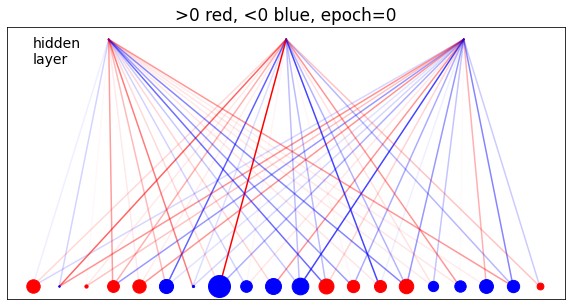

In [4]:
def create_coord(np,x0,f=1.0):
    x=[x0] * np
    print(x)
    y=list(range(np))
    for i in range(np):
        y[i] = f*(y[i]/(np-1.) - 0.5)
    return (x,y)
(x1,y1)=create_coord(L,0)
(x2,y2)=create_coord(M,1,f=0.7)

def mycolor(val):
    if val>0: return 'red'
    elif val<0: return 'blue'
    else: return 'black'

def plotgraph_vert(epoch=0):
    A=2./w.max()
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i],x2[j]),(y1[i],y2[j]),mycolor(w[i][j])
            plt.plot(ex, ey, col, zorder=1, lw=A*abs(w[i][j]))
    # Scatter plot on top of lines
    
    A=300./(a.max()+b.max())
    
    for i in range(L):
        plt.scatter(x1[i], y1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))

    for j in range(M):
        plt.scatter(x2[j], y2[j], s=A*abs(b[j]), zorder=2, c=mycolor(b[j]), marker="s")
    plt.figaspect(1)
    plt.title(f'>0 red, <0 blue, epoch={epoch}')
    plt.show()
    
def plotgraph(epoch=0):
    fig, ax = plt.subplots(1,1 , figsize=(10, 5))
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    
    A=1./max(w.max(),-w.min())
    for i in range(L):
        for j in range(M):
            ex, ey, col = (y1[i],y2[j]),(x1[i],x2[j]),mycolor(w[i][j])
            ax.plot(ex, ey, col, zorder=1, alpha=A*abs(w[i][j]))
    # Scatter plot on top of lines
    #A=300./(a.max()+b.max())
    A=500.
    for i in range(L):
        ax.scatter(y1[i],x1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))
    for j in range(M):
        ax.scatter(y2[j], x2[j], s=min(300,A*abs(b[j])), zorder=2, c=mycolor(b[j]), marker="s")
    ax.set_title(f'>0 red, <0 blue, epoch={epoch}')
    ax.text(-0.5,0.9,"hidden\nlayer")
    plt.show()
                  
plotgraph()

In [5]:

# eq(213) page 97, activation via sigmoid
# taking into account energy gap DE=2 for "spin" variables (-1,1)
def activate(v_in,wei,bias,DE,info=False): #here activate has to be modified to preserve the one hot encoded structure of the data!
    act = np.dot(v_in, wei) + bias
    n = np.shape(act)
    prob = 1. / (1. + exp(-DE*act))
    v_out = np.full(n, vmin, dtype=int) # a list on -1's or 0's
    v_out[np.random.random_sample(n) < prob] = 1 # activate the 1's with probability prob
    if info:
        print('input=', v_in)
        print('act=',act)
        print('prob=',prob)
        print('output=',v_out)
    return v_out

k = 0
activate(v[k],w,b,GAP,info=True)
import random

def Energy(v,h,wei,a):
    return -np.dot(a,v)-np.dot(np.dot(v,wei),h)
 
def activate_mod(h,wei,a,DE):
    if SPINS==False:
        vo=[]
        for i in range(0,5):
            Z=np.exp(-DE*Energy([1,0,0,0],h,wei[4*i:4*(i+1),:],a[4*i:4*(i+1)]))+np.exp(-DE*Energy([0,1,0,0],h,wei[4*i:4*(i+1),:],a[4*i:4*(i+1)]))+np.exp(-DE*Energy([0,0,1,0],h,wei[4*i:4*(i+1),:],a[4*i:4*(i+1)]))+np.exp(-DE*Energy([0,0,0,1],h,wei[4*i:4*(i+1),:],a[4*i:4*(i+1)]))
            probs=[np.exp(-DE*Energy([1,0,0,0],h,wei[4*i:4*(i+1),:],a[4*i:4*(i+1)]))/Z,np.exp(-DE*Energy([0,1,0,0],h,wei[4*i:4*(i+1),:],a[4*i:4*(i+1)]))/Z,np.exp(-DE*Energy([0,0,1,0],h,wei[4*i:4*(i+1),:],a[4*i:4*(i+1)]))/Z,np.exp(-DE*Energy([0,0,0,1],h,wei[4*i:4*(i+1),:],a[4*i:4*(i+1)]))/Z]
            vo+=random.choices([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]],probs)
        return np.concatenate(vo)
    if SPINS==True:
        vo=[]
        for i in range(0,5):
            Z=np.exp(-DE*Energy([1,-1,-1,-1],h,wei[4*i:4*(i+1),:],a[4*i:4*(i+1)]))+np.exp(-DE*Energy([-1,1,-1,-1],h,wei[4*i:4*(i+1),:],a[4*i:4*(i+1)]))+np.exp(-DE*Energy([-1,-1,1,-1],h,wei[4*i:4*(i+1),:],a[4*i:4*(i+1)]))+np.exp(-DE*Energy([-1,-1,-1,1],h,wei[4*i:4*(i+1),:],a[4*i:4*(i+1)]))
            probs=[np.exp(-DE*Energy([1,-1,-1,-1],h,wei[4*i:4*(i+1),:],a[4*i:4*(i+1)]))/Z,np.exp(-DE*Energy([-1,1,-1,-1],h,wei[4*i:4*(i+1),:],a[4*i:4*(i+1)]))/Z,np.exp(-DE*Energy([-1,-1,1,-1],h,wei[4*i:4*(i+1),:],a[4*i:4*(i+1)]))/Z,np.exp(-DE*Energy([-1,-1,-1,1],h,wei[4*i:4*(i+1),:],a[4*i:4*(i+1)]))/Z]
            vo+=random.choices([[1,-1,-1,-1],[-1,1,-1,-1],[-1,-1,1,-1],[-1,-1,-1,1]],probs)
        return np.concatenate(vo)

# Funzione ricorsiva per generare tutti i possibili vettori binari divisi in 5 blocchi
def generate_vectors(blocks, current_vector, index, all_vectors):
    if index == 5:
        all_vectors.append(current_vector)
        return
    for block in blocks:
        if block in current_vector:
            continue
        new_vector = current_vector.copy()
        new_vector[index*4:(index+1)*4] = block
        generate_vectors(blocks, new_vector, index+1, all_vectors)
# Creazione dei blocchi one-hot-encoded
blocks = []
block_h=[]
if SPINS==False: 
    for i in range(4):
        block = [0] * 4
        block[i] = 1
        blocks.append(tuple(block))
    hs= list(product([0, 1], repeat= M))

else:
    for i in range(4):
        block = [-1] * 4
        block[i] = 1
        blocks.append(tuple(block))
    hs= list(product([1, -1], repeat= M))



# Generazione di tutti i possibili vettori binari divisi in 5 blocchi
vectors = []
generate_vectors(blocks, [0]*20, 0, vectors)

#print(vectors)
#print(hs)


input= [0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0]
act= [ 0.54815639 -1.50095968 -0.83278223]
prob= [0.63370775 0.18228243 0.3030571 ]
output= [1 0 0]


## Original RBM train (point0)



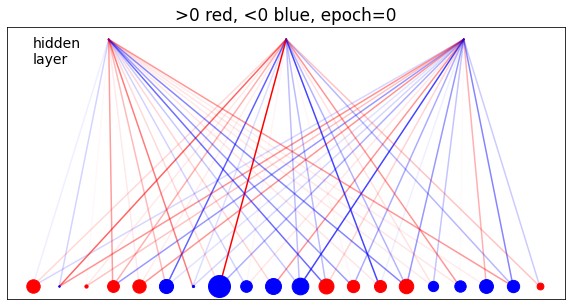

----------- epoch = 0   k= 499   m= 500
dw = [[-0.214 -0.24  -0.096]
 [-0.204 -0.222 -0.11 ]
 [-0.204 -0.29  -0.134]
 [-0.26  -0.314 -0.144]
 [-0.238 -0.336 -0.146]
 [-0.07  -0.08  -0.034]
 [-0.202 -0.194 -0.066]
 [-0.172 -0.158 -0.058]
 [-0.13  -0.086 -0.072]
 [-0.12  -0.104 -0.046]
 [ 0.016 -0.052  0.006]
 [-0.166 -0.23  -0.084]
 [-0.144 -0.188 -0.086]
 [-0.08  -0.17  -0.066]
 [-0.098 -0.072  0.016]
 [-0.148 -0.144 -0.07 ]
 [-0.178 -0.168 -0.082]
 [-0.104 -0.114 -0.032]
 [-0.126 -0.178 -0.036]
 [-0.186 -0.25  -0.092]]
da = [-0.352 -0.358 -0.288 -0.374 -0.376 -0.09  -0.31  -0.218 -0.182 -0.206
  0.024 -0.288 -0.23  -0.196 -0.144 -0.238 -0.264 -0.172 -0.146 -0.298]
db = [-0.06  -0.124  0.044]
----------- epoch = 1   k= 499   m= 500
dw = [[-0.03762376  0.0019802  -0.00594059]
 [-0.01386139 -0.0019802   0.00594059]
 [ 0.06534653 -0.05148515 -0.02970297]
 [ 0.01980198 -0.03168317 -0.01980198]
 [ 0.01980198 -0.04950495 -0.03960396]
 [ 0.02970297 -0.01782178 -0.02178218]
 [-0.03366337  0.00

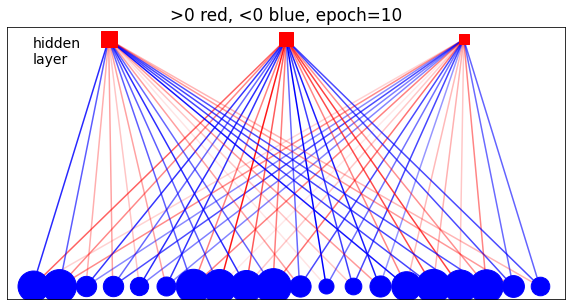

l_rate =  0.9090909090909092


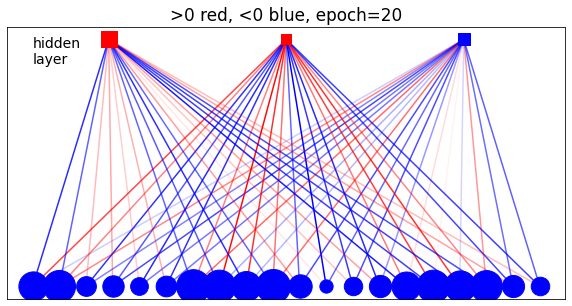

l_rate =  0.8333333333333337


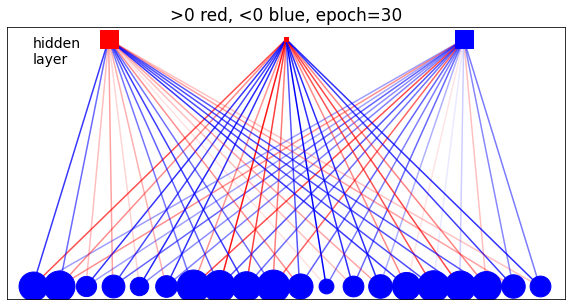

l_rate =  0.7692307692307697


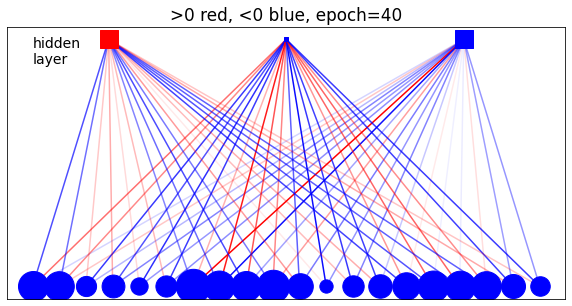

l_rate =  0.7142857142857149


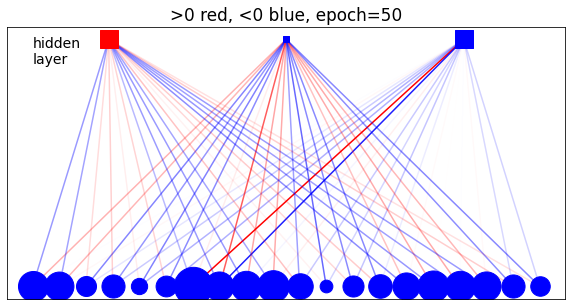

l_rate =  0.6666666666666671


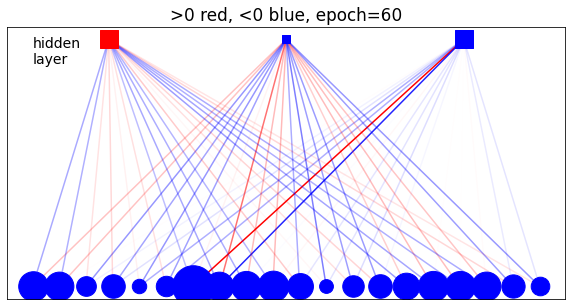

l_rate =  0.6250000000000006


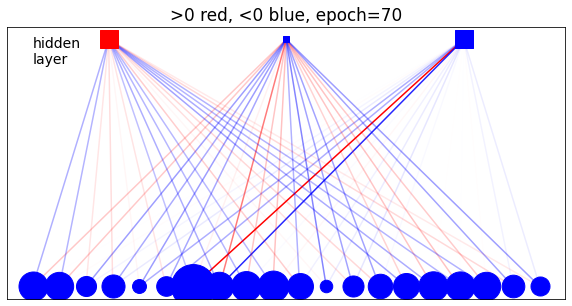

l_rate =  0.5882352941176475


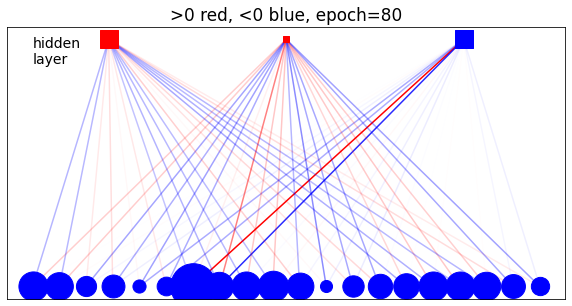

l_rate =  0.555555555555556


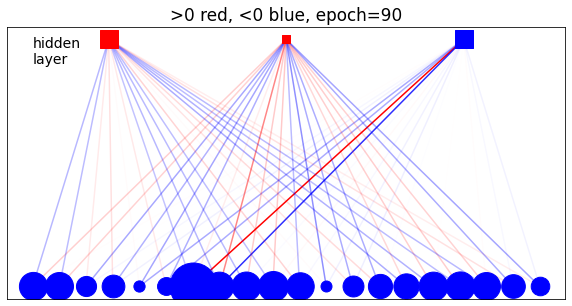

l_rate =  0.5263157894736847


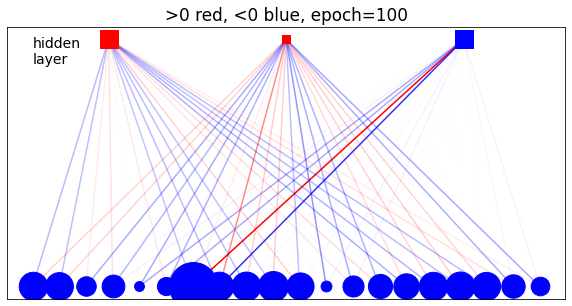

l_rate =  0.5000000000000009


In [6]:
# random seed for reproducibility
np.random.seed(12345)

plotgraph(0)

# learning rate
l_rate = 1.0

# minibatch
mini, m = 500, 0
like=[]
# train model
print('===================================================')
en=[]
for epoch in range(100):
    # aggregate normalization of batch statistics and learning rate
    l_rate_m = l_rate / mini
    en_data=[]
    en_model=[]
    for k in range(N):
        if m==0:
            # initialize averages in miniblock
            v_data, v_model = np.zeros(L),np.zeros(L)
            h_data, h_model = np.zeros(M),np.zeros(M)
            vh_data,vh_model= np.zeros((L,M)),np.zeros((L,M))

        # positive CD phase: generating h 
        h = activate(v[k],w,b,GAP)
        # negative CD phase: generating fantasy vf
        vf = activate(h,w.T,a,GAP)
        # one more positive CD phase: generating fantasy h from fantasy vf 
        hf = activate(vf,w,b,GAP)

        v_data  += v[k]
        v_model += vf
        h_data  += h
        h_model += hf
        vh_data += np.outer(v[k].T,h)
        vh_model+= np.outer(vf.T,hf)
        
        
        m += 1
        # minibatch
        if m==mini:
            # gradient of the likelihood: follow it along its positive direction
            # with a "vanilla" SGD
            dw = l_rate_m*(vh_data - vh_model)
            da = l_rate_m*(v_data - v_model)
            db = l_rate_m*(h_data - h_model)
            if epoch<=1 and k<=mini:
                print('----------- epoch =',epoch,'  k=',k,'  m=',m)
                print('dw =',dw)
                print('da =',da)
                print('db =',db)
            # basic step of vanilla gradient descent, from eq.(211)
            w = w + dw
            a = a + da
            b = b + db
            
            en_model.append(-np.dot(a,v_model)-np.dot(b,h_model)-np.dot(np.dot(v_model,w),h_model))
            en_data.append((-np.dot(a,v_data)-np.dot(b,h_data)-np.dot(np.dot(v_data,w),h_data)))
            w1=w
            m=0
            
            
                           
    Z=0
    for i in range(len(hs)):
        for j in range(len(vectors)):
            Z+=np.exp(np.dot(a,vectors[j])+np.dot(b,hs[i])+np.dot(np.dot(vectors[j],w),hs[i]))
    like.append(np.mean([np.log(sum([np.exp(np.dot(a,v[i])+np.dot(b,h)+np.dot(np.dot(v[i],w),h)) for h in hs])/Z) for i in range(N)]))
    en.append(abs(np.mean(en_model)-np.mean(en_data)))
    
    # randomize the order of input data
    np.random.shuffle(v)
    # decrease the learning rate (here as a power law)
    l_rate = l_rate / (0.01 * l_rate + 1)
    if epoch%10==9:
        plotgraph(epoch+1)
        print('l_rate = ',l_rate)

## RBM train with RMSprop (point2)



In [7]:
# range of each initial weight
sigma = sqrt(4. / float(L + M))
# random seed for reproducibility
np.random.seed(12345)
# initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
w = sigma * np.random.randn(L,M)
a = sigma * np.random.randn(L)
b = np.zeros(M)
print("w=",w);print("a=",a);print("b=",b)
w0,a0,b0=np.copy(w),np.copy(a),np.copy(b)

w= [[-8.53689953e-02  1.99733179e-01 -2.16620919e-01]
 [-2.31755558e-01  8.19787168e-01  5.81090402e-01]
 [ 3.87452630e-02  1.17496268e-01  3.20704580e-01]
 [ 5.19799217e-01  4.20026997e-01 -5.40561570e-01]
 [ 1.14679439e-01  9.54632696e-02  5.64205322e-01]
 [ 3.69666589e-01 -8.34740462e-01 -1.55069058e-01]
 [ 6.96031669e-01 -1.82896223e-01 -2.25087743e-01]
 [ 1.98916500e-01  1.35490328e+00 -4.25881318e-01]
 [-2.40662042e-01  5.17621501e-02  1.26198579e-01]
 [ 2.18428052e-01  3.92122939e-04  5.60407423e-01]
 [-2.97568412e-01 -3.46614986e-01 -9.88454929e-01]
 [-7.75990891e-01 -3.58960649e-01  2.33596735e-01]
 [-5.27931178e-01  4.99713654e-02 -4.43515350e-01]
 [ 1.38821689e-01 -9.83945660e-01 -8.32151648e-02]
 [-6.43056588e-01 -4.04824860e-01 -5.45069294e-01]
 [ 1.19416099e-01  1.57630271e-01 -3.14392418e-01]
 [ 1.38155666e-01  5.62881414e-01  2.91405937e-02]
 [ 1.02870215e-01 -4.94662959e-03  4.19035400e-01]
 [ 5.53478414e-01 -3.83358570e-01 -6.46022043e-01]
 [ 9.25161718e-03  3.1625929

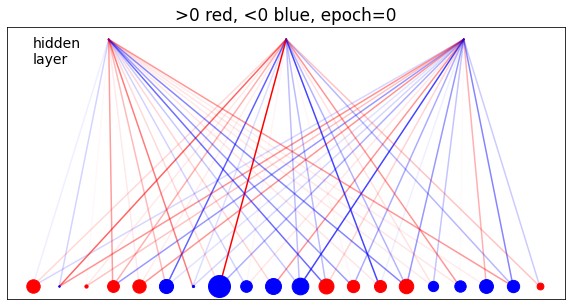

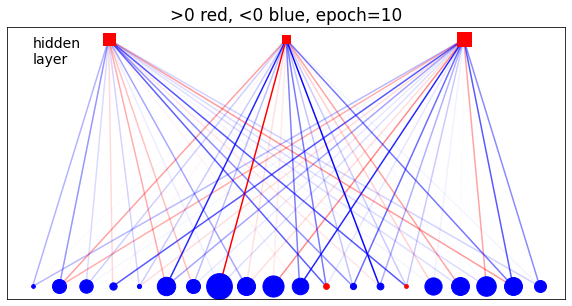

l_rate =  0.9090909090909092


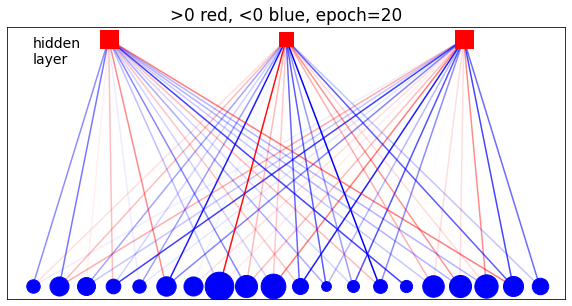

l_rate =  0.8333333333333337


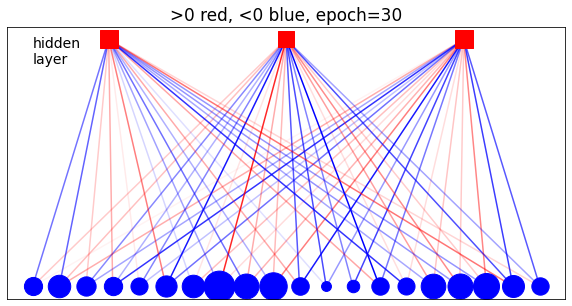

l_rate =  0.7692307692307697


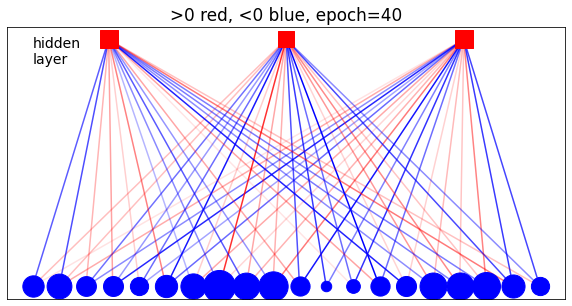

l_rate =  0.7142857142857149


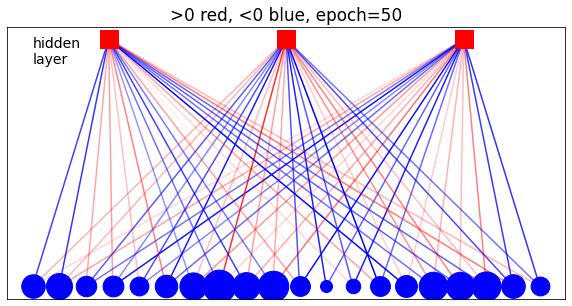

l_rate =  0.6666666666666671


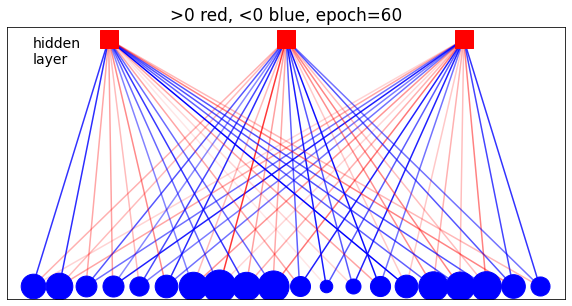

l_rate =  0.6250000000000006


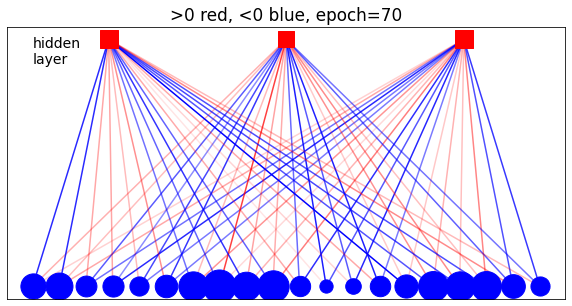

l_rate =  0.5882352941176475


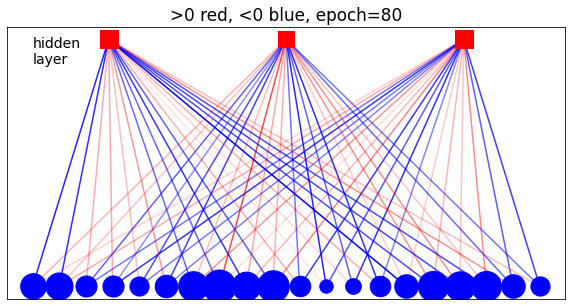

l_rate =  0.555555555555556


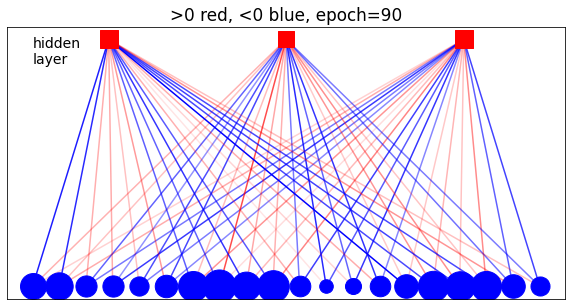

l_rate =  0.5263157894736847


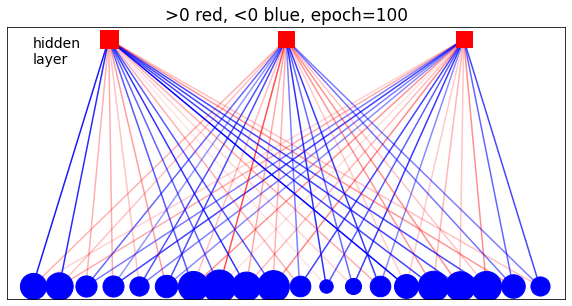

l_rate =  0.5000000000000009


In [8]:
# random seed for reproducibility
np.random.seed(12345)
plotgraph(0)
#learning rate
l_rate = 1.0
#minibatch
mini, m = 500, 0 #m starts equal to zero 

w = sigma * np.random.randn(L,M)
a = sigma * np.random.randn(L)
b = np.zeros(M)

beta=0.9
epsilon=1e-8
dw_rms=np.zeros((L,M))
da_rms=np.zeros(L)
db_rms=np.zeros(M)
likerms=[]
en1=[]
# train model
print('===================================================')
for epoch in range(100):
    en_data=[]
    en_model=[]
    # aggregate normalization of batch statistics and learning rate
    l_rate_m = l_rate / mini
    for k in range(N): #analize each row of trainin data
        if m==0: 
            #initialize averages in miniblock
            v_data, v_model = np.zeros(L),np.zeros(L)
            h_data, h_model = np.zeros(M),np.zeros(M)
            vh_data,vh_model= np.zeros((L,M)),np.zeros((L,M))
 
        # positive CD phase: generating h activations
        h = activate(v[k],w,b,GAP)
        # negative CD phase: generating fantasy vf from the h activations
        vf = activate(h,w.T,a,GAP)#activate(h,w.T,a,GAP)
        # one more positive CD phase: generating fantasy h from fantasy vf again 
        hf = activate(vf,w,b,GAP)
        #backward contrastive divergence: backward step
        #vf1= activate(hf,w.T,a,GAP)#activate_mod(hf,w,a,b,GAP)
        #backward contrastive divergence: forward step 
        #hf1= activate(vf1,w,b,GAP)
        

        v_data  += v[k] #trainig data
        v_model += vf #fantasy data
        h_data  += h #h activations calculated with training data
        h_model += hf # fantasy h calculated with fantasy data
        vh_data += np.outer(v[k].T,h) # calculate positive phase 
        vh_model+= np.outer(vf.T,hf) #calculate negative phase 
        
    
        m += 1 #m raised by one in this way at k==500 the following piece of code happens 
        # minibatch
        if m==mini:
            # gradient of the likelihood: follow it along its positive direction
            # with a "vanilla" SGD
            #calculate updates for weights and biases 
            dw = l_rate_m*(vh_data - vh_model)
            da = l_rate_m*(v_data - v_model)
            db = l_rate_m*(h_data - h_model)
            
            dw_rms=beta*dw_rms+(1-beta)*np.square(dw/l_rate_m)
            da_rms=beta*da_rms+(1-beta)*np.square(da/l_rate_m)
            db_rms=beta*db_rms+(1-beta)*np.square(db/l_rate_m)
            
            dw_update= dw/(np.sqrt(dw_rms+epsilon))
            da_update= da/(np.sqrt(da_rms+epsilon))
            db_update= db/(np.sqrt(db_rms+epsilon))
            
            #if epoch<=1 and k<=mini:
                #print('----------- epoch =',epoch,'  k=',k,'  m=',m)
                #print('dw =',dw)
                #print('da =',da)
                #print('db =',db)
            # basic step of vanilla gradient descent, from eq.(211)
            #updates weights and biases 
            w = w + dw_update
            a = a + da_update
            b = b + db_update
            en_model.append(-np.dot(a,v_model)-np.dot(b,h_model)-np.dot(np.dot(v_model,w),h_model))
            en_data.append((-np.dot(a,v_data)-np.dot(b,h_data)-np.dot(np.dot(v_data,w),h_data)))
            m=0 #puts m to zero and starts again 
            w_rbm=w
    Z=0
    for i in range(len(hs)):
        for j in range(len(vectors)):
            Z+=np.exp(np.dot(a,vectors[j])+np.dot(b,hs[i])+np.dot(np.dot(vectors[j],w),hs[i]))
    likerms.append(np.mean([np.log(sum([np.exp(np.dot(a,v[i])+np.dot(b,h)+np.dot(np.dot(v[i],w),h)) for h in hs])/Z) for i in range(N)]))
    en1.append(abs(np.mean(en_model)-np.mean(en_data)))
    
    # randomize the order of input data
    np.random.shuffle(v)
    # decrease the learning rate (here as a power law)
    l_rate = l_rate / (0.01 * l_rate + 1)
    if epoch%10==9:
        plotgraph(epoch+1)
        print('l_rate = ',l_rate)
   



## RBM train with more CD steps RMSprop (point3)

In [9]:

# range of each initial weight
sigma = sqrt(4. / float(L + M))
# random seed for reproducibility
np.random.seed(12345)
# initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
w = sigma * np.random.randn(L,M)
a = sigma * np.random.randn(L)
b = np.zeros(M)
print("w=",w);print("a=",a);print("b=",b)
w0,a0,b0=np.copy(w),np.copy(a),np.copy(b)

w= [[-8.53689953e-02  1.99733179e-01 -2.16620919e-01]
 [-2.31755558e-01  8.19787168e-01  5.81090402e-01]
 [ 3.87452630e-02  1.17496268e-01  3.20704580e-01]
 [ 5.19799217e-01  4.20026997e-01 -5.40561570e-01]
 [ 1.14679439e-01  9.54632696e-02  5.64205322e-01]
 [ 3.69666589e-01 -8.34740462e-01 -1.55069058e-01]
 [ 6.96031669e-01 -1.82896223e-01 -2.25087743e-01]
 [ 1.98916500e-01  1.35490328e+00 -4.25881318e-01]
 [-2.40662042e-01  5.17621501e-02  1.26198579e-01]
 [ 2.18428052e-01  3.92122939e-04  5.60407423e-01]
 [-2.97568412e-01 -3.46614986e-01 -9.88454929e-01]
 [-7.75990891e-01 -3.58960649e-01  2.33596735e-01]
 [-5.27931178e-01  4.99713654e-02 -4.43515350e-01]
 [ 1.38821689e-01 -9.83945660e-01 -8.32151648e-02]
 [-6.43056588e-01 -4.04824860e-01 -5.45069294e-01]
 [ 1.19416099e-01  1.57630271e-01 -3.14392418e-01]
 [ 1.38155666e-01  5.62881414e-01  2.91405937e-02]
 [ 1.02870215e-01 -4.94662959e-03  4.19035400e-01]
 [ 5.53478414e-01 -3.83358570e-01 -6.46022043e-01]
 [ 9.25161718e-03  3.1625929

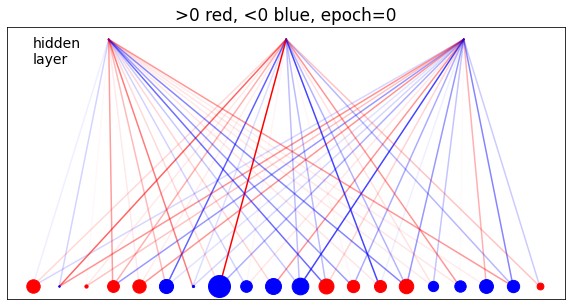

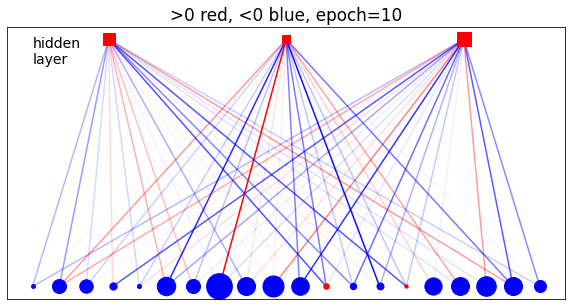

l_rate =  0.9090909090909092


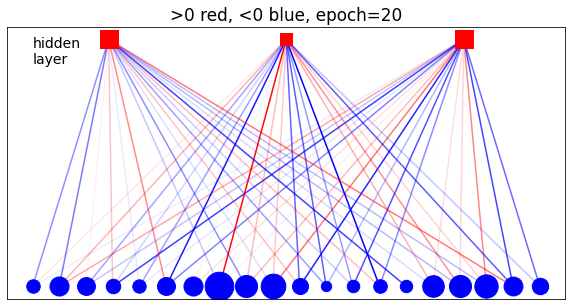

l_rate =  0.8333333333333337


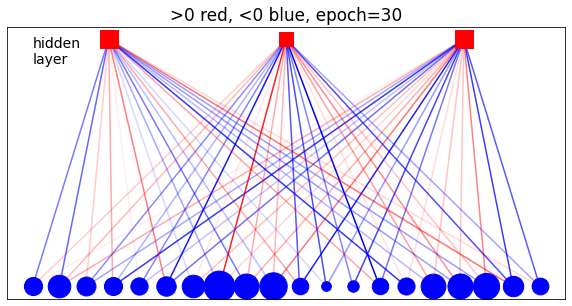

l_rate =  0.7692307692307697


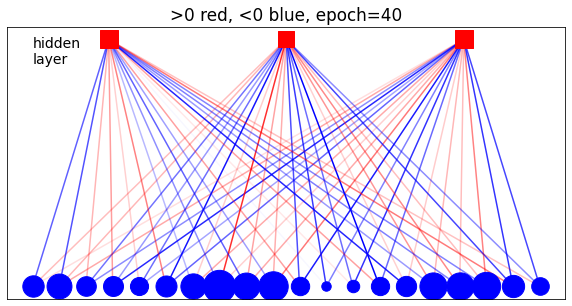

l_rate =  0.7142857142857149


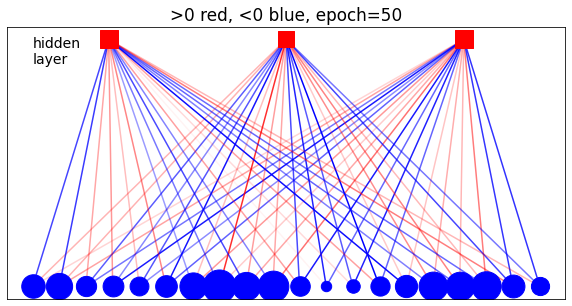

l_rate =  0.6666666666666671


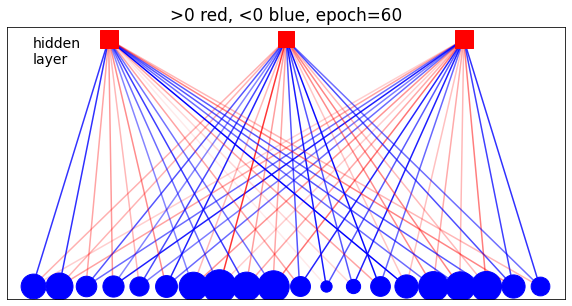

l_rate =  0.6250000000000006


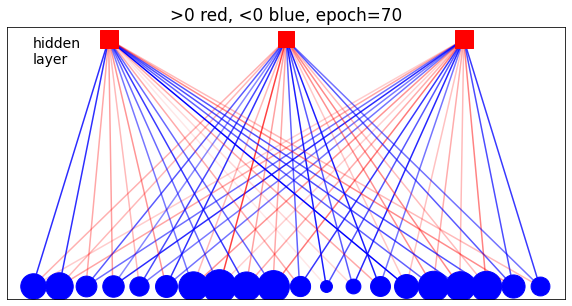

l_rate =  0.5882352941176475


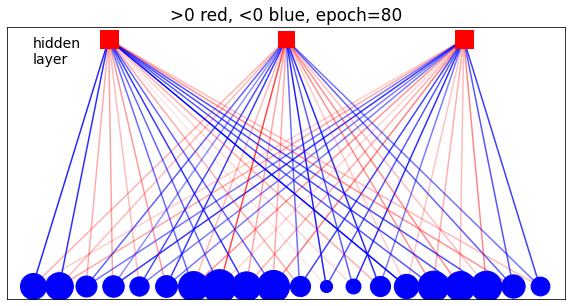

l_rate =  0.555555555555556


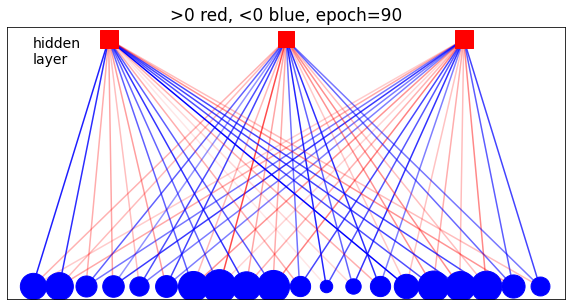

l_rate =  0.5263157894736847


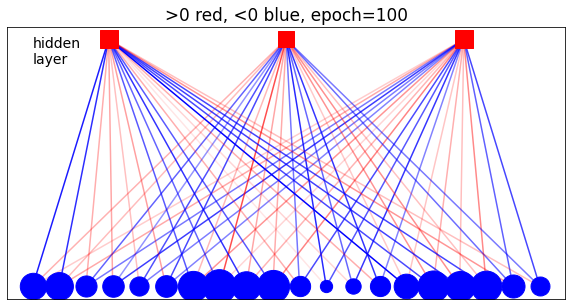

l_rate =  0.5000000000000009


In [10]:
# random seed for reproducibility
np.random.seed(12345)
plotgraph(0)
#learning rate
l_rate = 1.0
#minibatch
mini, m = 500, 0 #m starts equal to zero 

beta=0.9
epsilon=1e-8
dw_rms=np.zeros((L,M))
da_rms=np.zeros(L)
db_rms=np.zeros(M)
likerms1=[]
en2=[]
# train model
print('===================================================')
for epoch in range(100):
    en_data=[]
    en_model=[]
    # aggregate normalization of batch statistics and learning rate
    l_rate_m = l_rate / mini
    for k in range(N): #analize each row of trainin data
        if m==0: 
            #initialize averages in miniblock
            v_data, v_model = np.zeros(L),np.zeros(L)
            h_data, h_model = np.zeros(M),np.zeros(M)
            vh_data,vh_model= np.zeros((L,M)),np.zeros((L,M))
 
        # positive CD phase: generating h activations
        h = activate(v[k],w,b,GAP)
        # negative CD phase: generating fantasy vf from the h activations
        vf = activate(h,w.T,a,GAP)#activate(h,w.T,a,GAP)
        # one more positive CD phase: generating fantasy h from fantasy vf again 
        hf = activate(vf,w,b,GAP)
        #backward contrastive divergence: backward step
        vf1= activate(hf,w.T,a,GAP)#activate_mod(hf,w,a,b,GAP)
        #backward contrastive divergence: forward step 
        hf1= activate(vf1,w,b,GAP)
        vf2= activate(hf1,w.T,a,GAP)
        hf2= activate(vf2,w,b,GAP)
        vf3= activate(hf2,w.T,a,GAP)
        hf3= activate(vf3,w,b,GAP)
        

        v_data  += v[k] #trainig data
        v_model += vf3 #fantasy data
        h_data  += h #h activations calculated with training data
        h_model += hf3 # fantasy h calculated with fantasy data
        vh_data += np.outer(v[k].T,h) # calculate positive phase 
        vh_model+= np.outer(vf3.T,hf3) #calculate negative phase 
        
        en_model.append(-np.dot(a,vf3)-np.dot(b,hf3)-np.dot(np.dot(vf3,w),hf3))
        en_data.append((-np.dot(a,v[k])-np.dot(b,h)-np.dot(np.dot(v[k],w),h)))
    
    
        m += 1 #m raised by one in this way at k==500 the following piece of code happens 
        # minibatch
        if m==mini:
            # gradient of the likelihood: follow it along its positive direction
            # with a "vanilla" SGD
            #calculate updates for weights and biases 
            dw = l_rate_m*(vh_data - vh_model)
            da = l_rate_m*(v_data - v_model)
            db = l_rate_m*(h_data - h_model)
            
            dw_rms=beta*dw_rms+(1-beta)*np.square(dw/l_rate_m)
            da_rms=beta*da_rms+(1-beta)*np.square(da/l_rate_m)
            db_rms=beta*db_rms+(1-beta)*np.square(db/l_rate_m)
            
            dw_update= dw/(np.sqrt(dw_rms+epsilon))
            da_update= da/(np.sqrt(da_rms+epsilon))
            db_update= db/(np.sqrt(db_rms+epsilon))
            
            
            #if epoch<=1 and k<=mini:
                #print('----------- epoch =',epoch,'  k=',k,'  m=',m)
                #print('dw =',dw)
                #print('da =',da)
                #print('db =',db)
            # basic step of vanilla gradient descent, from eq.(211)
            #updates weights and biases 
            
            
            w = w + dw_update
            a = a + da_update
            b = b + db_update
            w_rbm1=w
            m=0 #puts m to zero and starts again 
            
            
            en_model.append(-np.dot(a,v_model)-np.dot(b,h_model)-np.dot(np.dot(v_model,w),h_model))
            en_data.append((-np.dot(a,v_data)-np.dot(b,h_data)-np.dot(np.dot(v_data,w),h_data)))
    
    
    Z=0
    for i in range(len(hs)):
        for j in range(len(vectors)):
            Z+=np.exp(np.dot(a,vectors[j])+np.dot(b,hs[i])+np.dot(np.dot(vectors[j],w),hs[i]))
    likerms1.append(np.mean([np.log(sum([np.exp(np.dot(a,v[i])+np.dot(b,h)+np.dot(np.dot(v[i],w),h)) for h in hs])/Z) for i in range(N)]))
    en2.append(abs(np.mean(en_model)-np.mean(en_data)))
    # randomize the order of input data
    np.random.shuffle(v)
    # decrease the learning rate (here as a power law)
    l_rate = l_rate / (0.01 * l_rate + 1)
    if epoch%10==9:
        plotgraph(epoch+1)
        print('l_rate = ',l_rate)
        


## RBM train with BCD and RMSprop(point 4)



In [11]:

# range of each initial weight
sigma = sqrt(4. / float(L + M))
# random seed for reproducibility
np.random.seed(12345)
# initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
w = sigma * np.random.randn(L,M)
a = sigma * np.random.randn(L)
b = np.zeros(M)
print("w=",w);print("a=",a);print("b=",b)
w0,a0,b0=np.copy(w),np.copy(a),np.copy(b)

w= [[-8.53689953e-02  1.99733179e-01 -2.16620919e-01]
 [-2.31755558e-01  8.19787168e-01  5.81090402e-01]
 [ 3.87452630e-02  1.17496268e-01  3.20704580e-01]
 [ 5.19799217e-01  4.20026997e-01 -5.40561570e-01]
 [ 1.14679439e-01  9.54632696e-02  5.64205322e-01]
 [ 3.69666589e-01 -8.34740462e-01 -1.55069058e-01]
 [ 6.96031669e-01 -1.82896223e-01 -2.25087743e-01]
 [ 1.98916500e-01  1.35490328e+00 -4.25881318e-01]
 [-2.40662042e-01  5.17621501e-02  1.26198579e-01]
 [ 2.18428052e-01  3.92122939e-04  5.60407423e-01]
 [-2.97568412e-01 -3.46614986e-01 -9.88454929e-01]
 [-7.75990891e-01 -3.58960649e-01  2.33596735e-01]
 [-5.27931178e-01  4.99713654e-02 -4.43515350e-01]
 [ 1.38821689e-01 -9.83945660e-01 -8.32151648e-02]
 [-6.43056588e-01 -4.04824860e-01 -5.45069294e-01]
 [ 1.19416099e-01  1.57630271e-01 -3.14392418e-01]
 [ 1.38155666e-01  5.62881414e-01  2.91405937e-02]
 [ 1.02870215e-01 -4.94662959e-03  4.19035400e-01]
 [ 5.53478414e-01 -3.83358570e-01 -6.46022043e-01]
 [ 9.25161718e-03  3.1625929

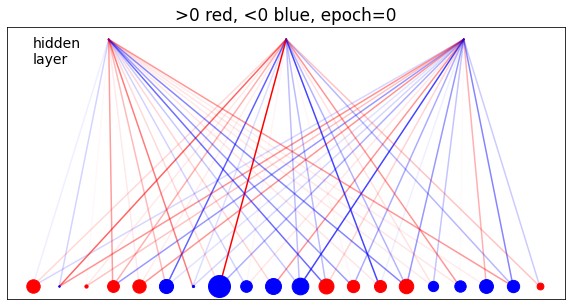

----------- epoch = 0   k= 499   m= 500
dw = [[ 0.054  0.046  0.022]
 [-0.018 -0.052 -0.058]
 [ 0.02   0.     0.02 ]
 [-0.046 -0.072 -0.044]
 [-0.094 -0.158 -0.136]
 [ 0.054 -0.002  0.01 ]
 [-0.006  0.     0.012]
 [ 0.056  0.082  0.054]
 [-0.014  0.03  -0.006]
 [-0.05  -0.038 -0.044]
 [ 0.116  0.024  0.022]
 [-0.042 -0.094 -0.032]
 [-0.026 -0.08  -0.07 ]
 [ 0.01  -0.03  -0.024]
 [ 0.016  0.01   0.018]
 [ 0.01   0.022  0.016]
 [-0.01  -0.026 -0.054]
 [ 0.006  0.024  0.012]
 [ 0.042 -0.008  0.02 ]
 [-0.028 -0.068 -0.038]]
da = [ 0.06  -0.08   0.048 -0.028 -0.188  0.118 -0.002  0.072  0.008 -0.076
  0.152 -0.084 -0.038  0.016  0.02   0.002 -0.058  0.008  0.082 -0.032]
db = [ 0.01  -0.078 -0.06 ]
----------- epoch = 1   k= 499   m= 500
dw = [[-0.02376238  0.05148515  0.03564356]
 [-0.02574257 -0.01584158 -0.00990099]
 [-0.00990099 -0.02772277 -0.04554455]
 [ 0.03960396 -0.02376238 -0.01782178]
 [ 0.04752475 -0.02574257 -0.03762376]
 [ 0.02772277 -0.02376238 -0.02970297]
 [-0.08118812  0.  

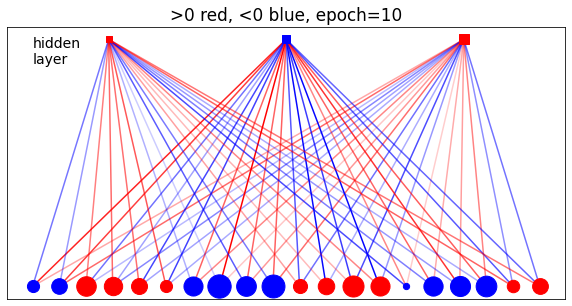

l_rate =  0.9090909090909092


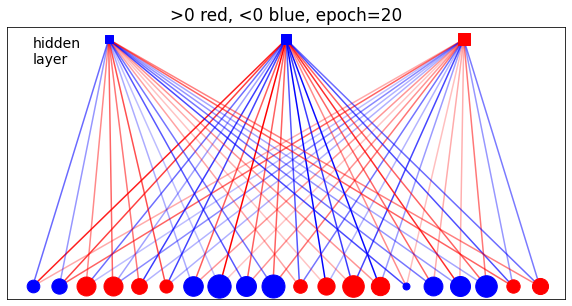

l_rate =  0.8333333333333337


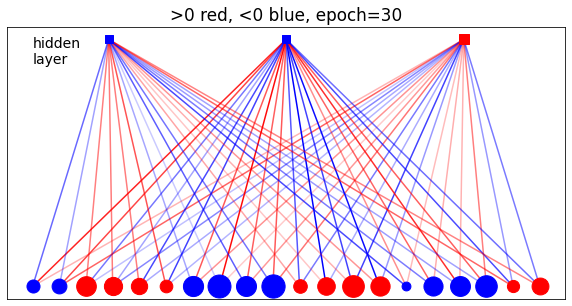

l_rate =  0.7692307692307697


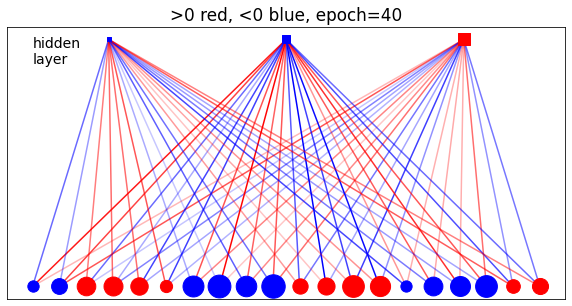

l_rate =  0.7142857142857149


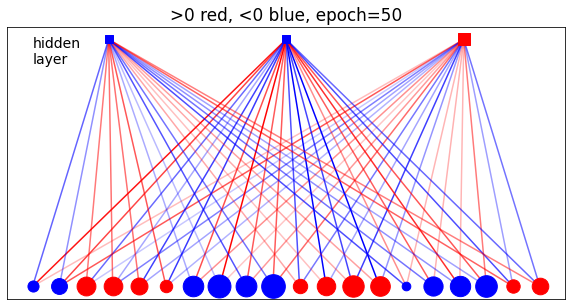

l_rate =  0.6666666666666671


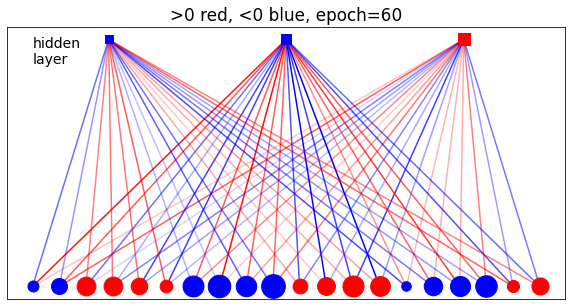

l_rate =  0.6250000000000006


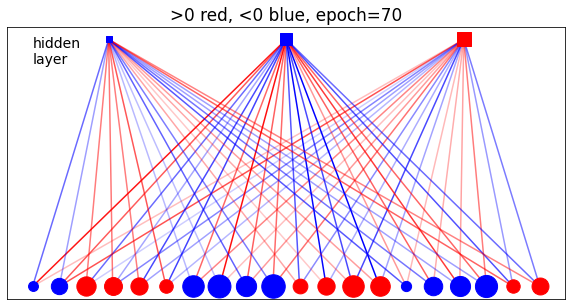

l_rate =  0.5882352941176475


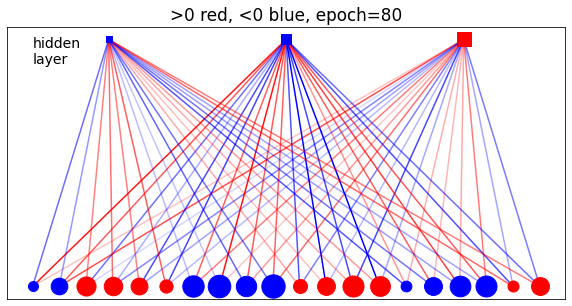

l_rate =  0.555555555555556


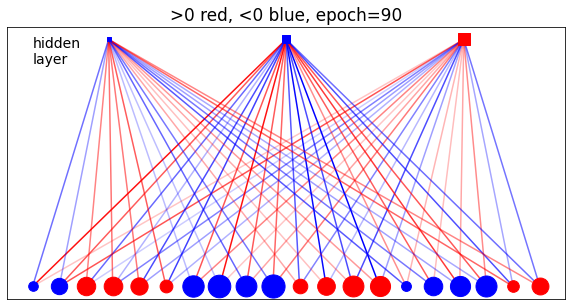

l_rate =  0.5263157894736847


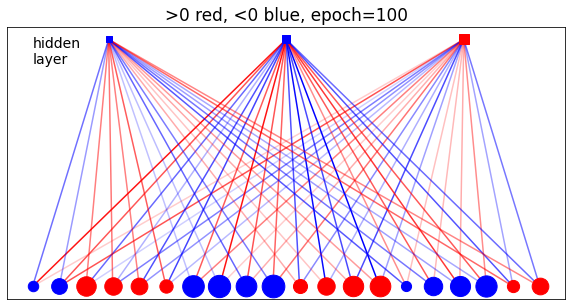

l_rate =  0.5000000000000009


In [12]:
# random seed for reproducibility
np.random.seed(12345)
plotgraph(0)
#learning rate
l_rate = 1.0
#minibatch
mini, m = 500, 0 

#m starts equal to zero

# RMSprop hyperparameters
beta = 0.9
epsilon = 1e-8
dw_rms = np.zeros((L, M))
da_rms = np.zeros(L)
db_rms = np.zeros(M)
likebcd=[]
en3=[]
# train model
print('===================================================')
for epoch in range(100):
    en_data=[]
    en_model=[]
    # aggregate normalization of batch statistics and learning rate
    l_rate_m = l_rate / mini
    for k in range(N): #analize each row of trainin data
        if m==0: 
            #initialize averages in miniblock
            v_data, v_model = np.zeros(L),np.zeros(L)
            h_data, h_model = np.zeros(M),np.zeros(M)
            vh_data,vh_model= np.zeros((L,M)),np.zeros((L,M))
 
        # positive CD phase: generating h activations
        h = activate(v[k],w,b,GAP)
        # negative CD phase: generating fantasy vf from the h activations
        vf = activate_mod(h,w,a,GAP)#activate(h,w.T,a,GAP)
        # one more positive CD phase: generating fantasy h from fantasy vf again 
        hf = activate(vf,w,b,GAP)
        #backward contrastive divergence: backward step
        vf1= activate_mod(hf,w,a,GAP)
        #backward contrastive divergence: forward step 
        hf1= activate(vf1,w,b,GAP)
        

        v_data  += v[k] #trainig data
        v_model += vf1 #fantasy data
        h_data  += h #h activations calculated with training data
        h_model += hf1 # fantasy h calculated with fantasy data
        vh_data += np.outer(v[k].T,h) # calculate positive phase 
        vh_model+= np.outer(vf1.T,hf1) #calculate negative phase 
    
        m += 1 #m raised by one in this way at k==500 the following piece of code happens 
        # minibatch
        if m==mini:
            # gradient of the likelihood: follow it along its positive direction
            # with a "vanilla" SGD
            #calculate updates for weights and biases 
            dw = l_rate_m*(vh_data - vh_model)
            da = l_rate_m*(v_data - v_model)
            db = l_rate_m*(h_data - h_model)
            
            # update RMSprop accumulated gradients
            dw_rms = beta * dw_rms + (1 - beta) * np.square(dw/l_rate_m)
            da_rms = beta * da_rms + (1 - beta) * np.square(da/l_rate_m)
            db_rms = beta * db_rms + (1 - beta) * np.square(db/l_rate_m)
            
            # compute updates
            dw_update = dw / (np.sqrt(dw_rms + epsilon))
            da_update = da / (np.sqrt(da_rms + epsilon))
            db_update = db / (np.sqrt(db_rms + epsilon))
            if epoch<=1 and k<=mini:
                print('----------- epoch =',epoch,'  k=',k,'  m=',m)
                print('dw =',dw)
                print('da =',da)
                print('db =',db)
            # basic step of vanilla gradient descent, from eq.(211)
            #updates weights and biases 
            w = w + dw
            a = a + da
            b = b + db
            m=0 #puts m to zero and starts again 
           
            en_model.append(-np.dot(a,v_model)-np.dot(b,h_model)-np.dot(np.dot(v_model,w),h_model))
            en_data.append((-np.dot(a,v_data)-np.dot(b,h_data)-np.dot(np.dot(v_data,w),h_data)))
            w_rbm2=w
    
    
    Z=0
    for i in range(len(hs)):
        for j in range(len(vectors)):
            Z+=np.exp(np.dot(a,vectors[j])+np.dot(b,hs[i])+np.dot(np.dot(vectors[j],w),hs[i]))
    likebcd.append(np.mean([np.log(sum([np.exp(np.dot(a,v[i])+np.dot(b,h)+np.dot(np.dot(v[i],w),h)) for h in hs])/Z) for i in range(N)]))
    en3.append(abs(np.mean(en_model)-np.mean(en_data)))
    
    # randomize the order of input data
    np.random.shuffle(v)
    # decrease the learning rate (here as a power law)
    l_rate = l_rate / (0.01 * l_rate + 1)
    if epoch%10==9:
        plotgraph(epoch+1)
        print('l_rate = ',l_rate)
        




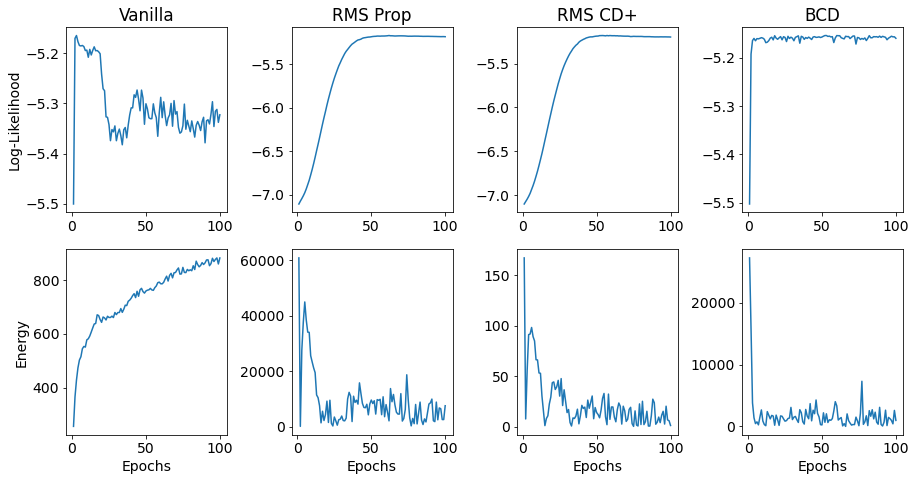

In [15]:
###PLOTS OF LOG_LIKELIHOOD AND ENERGY FOR SPINS=FALSE

fig, ax=plt.subplots(nrows=2, ncols=4)
fig.set_size_inches(15, 7.5)
ax[0,0].set_title('Vanilla') 
ax[0,0].set_ylabel('Log-Likelihood') 
ax[0,0].plot([i for i in range(1,101)],like)
ax[0,1].set_title('RMS Prop')
ax[0,1].plot([i for i in range(1,101)],likerms)
ax[0,2].set_title('RMS CD+') 
ax[0,2].plot([i for i in range(1,101)],likerms1)
ax[0,3].set_title('BCD') 
ax[0,3].plot([i for i in range(1,101)],likebcd)
ax[1,0].set_ylabel('Energy') 
ax[1,0].plot([i for i in range(1,101)],en)
ax[1,1].plot([i for i in range(1,101)],en1)
ax[1,2].plot([i for i in range(1,101)],en2)
ax[1,3].plot([i for i in range(1,101)],en3)
ax[1,0].set_xlabel('Epochs') 
ax[1,1].set_xlabel('Epochs') 
ax[1,2].set_xlabel('Epochs') 
ax[1,3].set_xlabel('Epochs') 
fig.subplots_adjust(wspace=0.4)



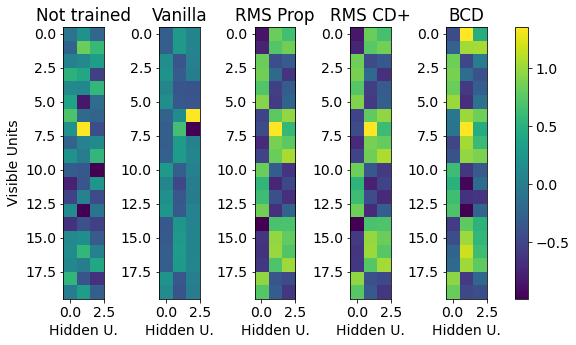

In [16]:
fig, ax=plt.subplots(nrows=1, ncols=5)
fig.set_size_inches(10, 5)
im0=ax[0].imshow(w0)
ax[1].imshow(w1)
ax[2].imshow(w_rbm)
ax[3].imshow(w_rbm1)
ax[4].imshow(w_rbm2)
ax[0].set_title('Not trained') 
ax[1].set_title('Vanilla') 
ax[2].set_title('RMS Prop')
ax[3].set_title('RMS CD+')
ax[4].set_title('BCD') 
#
ax[0].set_xlabel('Hidden U.') 
ax[1].set_xlabel('Hidden U.') 
ax[2].set_xlabel('Hidden U.') 
ax[3].set_xlabel('Hidden U.') 
ax[4].set_xlabel('Hidden U.') 
#
ax[0].set_ylabel('Visible Units') 
 
fig.subplots_adjust(wspace=0.5)
plt.colorbar(im0, ax=ax)
plt.show()